In [2]:
import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Common_Functions as cf 
from mpl_toolkits import mplot3d


In [3]:
df_pions = np.array(pd.read_csv('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Djuna_Data_Generation_Notebook/noshift1.csv',header = None))
train_x, train_y = cf.data_normaliser(df_pions[:-1000,:8]), df_pions[:-1000,-1]
val_x, val_y = cf.data_normaliser(df_pions[-1000:,:8]), df_pions[-1000:,-1]

In [4]:
opt = keras.optimizers.Adam(learning_rate= 0.005, beta_1 = 0.881, beta_2= 0.99)

In [7]:
def layers_tester(size_range,size_spacing,layer_range,repeats,section = 50000):
    min_size, max_size = size_range
    layer_min , layer_max = layer_range
    if (max_size-min_size)/size_spacing == int: 
        raise Exception('Spacing Must Be Integer U fuckwit')
    else:
        ##taking args of function and making 
        size_steps = int((max_size-min_size)/size_spacing)+1
        size_list = np.arange(start =int(min_size),stop = 1+(int(max_size)),step= size_spacing, dtype  = int)
        layer_range_list = range(layer_min,1+layer_max)
        ###Array for results 
        min_mape = np.zeros((size_steps,len(layer_range_list),repeats)) ###Axis 0:Size of Layers 1:Number of Layers 3:Number of repeats to take average over. 
        ### Running multiple DNNs
        for i in range(len(size_list)):
            print('Layers of Size',size_list[i])
            for j in range(len(layer_range_list)):
                print(layer_range_list[j],'Layers Deep')
                loop_layer_shape = size_list[i]*np.ones((layer_range_list[j]))
                #print(loop_layer_shape)
                for k in range(repeats):
                    mape_df = cf.trained_network(train_x[:section],train_y[:section],val_x,val_y,loop_layer_shape, optimizer= opt, verbose= 0).history['mean_absolute_percentage_error']
                    min_mape[i,j,k] = np.min(mape_df)
        return min_mape , layer_range_list, size_list

In [8]:
min_mape , layers, layer_sizes = layers_tester((24,28),1,(4,7),5)

Layers of Size 24
4 Layers Deep
5 Layers Deep
6 Layers Deep
7 Layers Deep
Layers of Size 25
4 Layers Deep
5 Layers Deep
6 Layers Deep
7 Layers Deep
Layers of Size 26
4 Layers Deep
5 Layers Deep
6 Layers Deep
7 Layers Deep
Layers of Size 27
4 Layers Deep
5 Layers Deep
6 Layers Deep
7 Layers Deep
Layers of Size 28
4 Layers Deep
5 Layers Deep
6 Layers Deep
7 Layers Deep


In [9]:
min_mape_2d = min_mape.reshape(min_mape.shape[0],-1)
np.savetxt('Min_Mape_of_varying_layer_shapes.csv',min_mape_2d,delimiter=',')

In [11]:
min_mape_mean_load = np.loadtxt('Min_Mape_of_varying_layer_shapes.csv',delimiter=',')
#min_mape_mean_load = min_mape_mean_load.reshape(4,10,5)
min_mape_mean  = np.mean(min_mape,axis = 2)

min_index = np.where(np.min(min_mape_mean)==min_mape_mean)


In [26]:
num_layers = np.ones_like(min_mape_mean)*np.array(layers)
num_layers = num_layers
layer_sizes_array = ((np.ones_like(min_mape_mean)).transpose()*layer_sizes).transpose()
print(num_layers.shape,layer_sizes_array.shape,min_mape_mean.shape)

(5, 4) (5, 4) (5, 4)


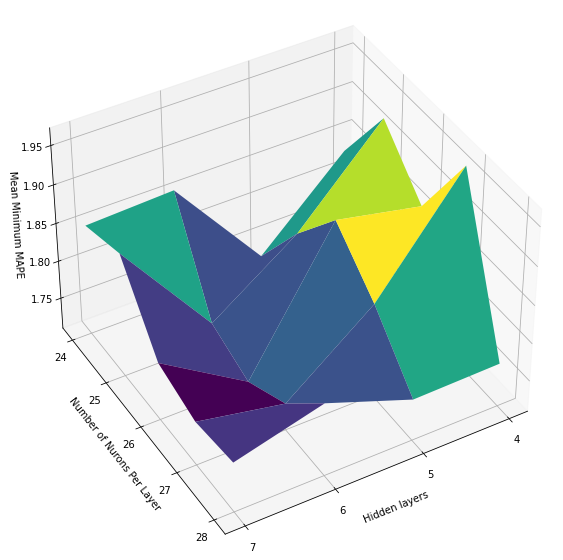

In [39]:

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(num_layers,layer_sizes_array,min_mape_mean,cmap = 'viridis')
#ax.scatter3D(3,18,min_mape_mean[3,3])
ax.view_init(40,60)
ax.set_xlabel('Hidden layers')
ax.set_ylabel('Number of Nurons Per Layer')
ax.set_zlabel('Mean Minimum MAPE')
ax.set_xticks((range(4,8)))
ax.set_yticks(range(24,29))

In [40]:
fig.savefig('../Figures/Layers_best.png',dpi = 300)

In [42]:
print('Optimised Layers =',num_layers[min_index],'Optimised Neuron_count= ', layer_sizes_array[min_index])
print('min_mape = ',np.min(min_mape_mean))

Optimised Layers = [6.] Optimised Neuron_count=  [26.]
min_mape =  1.714103674888611
